In [1]:
from Basics import *
setplot(dark=True)

# Fitting new distributions

In [ ]:

    # def matchdist(self, olddistx,olddisty, newdistx,newdisty):
    #     dx = (self.olddistx[1]-self.olddistx[0])
    #     pd.cut(newdistx, bins=np.arange(self.olddistx[0]-dx/2, self.olddistx[:-1]+dx, dx))
        
    #     self.zdistscale = self.zdistdf.groupby('zbin')[f"{self.zbin}_{self.hemisphere}"].sum().values*self.surveyarea
        
            

    
    
        # def gdist(self, **cosmopars):
    #     gdist = self.SMFraw*cosmopars["hh"]**3*self.SMF_to_N(**cosmopars)[:, None]
    #     if self.zweight=='True':
    #         self.LRGXcorrzdist()
    #         gdist = gdist*(self.zdistscale/np.sum(gdist, axis=1))[:, None]
    #     return gdist

    # def SMF(self, **cosmopars):
    #     SMF = self.SMFraw*cosmopars['hh']**3
    #     if self.zweight=='True':
    #         self.LRGXcorrzdist()
    #         SMF = SMF*(self.zdistscale/self.SMF_to_N(**cosmopars)/np.trapz(SMF, np.log10(self.mstars), axis=1))[:, None]
    #     return SMF
    
    # def LRGXcorrzdist(self):
    #     # Read in the redshift distribution for each specific bin
    #     # Number density in N / deg^2, dataframe with 1D arrays of length [ndim_zs_zdist]
    #     self.zdistdf = pd.read_csv(self.redshift_dist_file, sep=" ", skiprows=1, names=pd.read_csv(self.redshift_dist_file, sep=" ").columns[1:])
    #     self.zdist = self.zdistdf[f"{self.zbin}_{self.hemisphere}"]

    #     # Sort/group/sum up the finer redshift bins to match the bins of the SMF distribution
    #     self.zdistdf['zbin'] = pd.cut(self.zdistdf['zmin'], bins=np.arange(self.zs[0], self.zs[-1]+0.2, 0.1))
    #     self.zdistscale = self.zdistdf.groupby('zbin')[f"{self.zbin}_{self.hemisphere}"].sum().values*self.surveyarea
    

    
    
    
    # redshift_dist_file = "/global/cfs/projectdirs/desi/public/papers/c3/lrg_xcorr_2023/v1/redshift_dist/main_lrg_pz_dndz_iron_v0.4_dz_0.01.txt"  # arxiv.org/abs/2309.06443

In [358]:
zdistdf

,zmin,zmax,all_combined,bin_1_combined,bin_2_combined,bin_3_combined,bin_4_combined,all_north,bin_1_north,bin_2_north,bin_3_north,bin_4_north,all_south,bin_1_south,bin_2_south,bin_3_south,bin_4_south
0,0.00,0.01,0.008,0.001,0.001,0.001,0.001,0.009,0.000,0.002,0.002,0.001,0.007,0.001,0.001,0.001,0.001
1,0.01,0.02,0.008,0.001,0.001,0.001,0.001,0.005,0.000,0.002,0.000,0.000,0.010,0.001,0.000,0.002,0.002
2,0.02,0.03,0.023,0.002,0.001,0.002,0.004,0.018,0.000,0.000,0.002,0.007,0.025,0.003,0.002,0.002,0.002
3,0.03,0.04,0.042,0.005,0.005,0.004,0.004,0.039,0.006,0.006,0.006,0.005,0.043,0.004,0.004,0.003,0.004
4,0.04,0.05,0.054,0.005,0.006,0.003,0.002,0.036,0.003,0.005,0.002,0.002,0.062,0.006,0.006,0.003,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,1.44,1.45,0.019,0.000,0.001,0.002,0.001,0.017,0.000,0.002,0.002,0.000,0.019,0.001,0.000,0.002,0.002
145,1.45,1.46,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
146,1.46,1.47,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
147,1.47,1.48,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [ ]:
redshift_dist_file="/global/cfs/projectdirs/desi/public/papers/c3/lrg_xcorr_2023/v1/redshift_dist/main_lrg_pz_dndz_iron_v0.4_dz_0.01.txt"
zbin, hemisphere='bin_1', 'combined'
zdistdf = pd.read_csv(redshift_dist_file, sep=" ", skiprows=1, names=pd.read_csv(redshift_dist_file, sep=" ").columns[1:])
zdist = zdistdf[f"{zbin}_{hemisphere}"]

zs=np.linspace(0, 1, 10)
surveyarea=6000
# Sort/group/sum up the finer redshift bins to match the bins of the SMF distribution
zdistdf['zbin'] = pd.cut(zdistdf['zmin'], bins=np.arange(kroupass.z[0], kroupass.z[-1]+0.2, 0.1))
zdistscale = zdistdf.groupby('zbin', observed=False)[f"{zbin}_{hemisphere}"].sum().values*surveyarea

In [ ]:
filename = "/global/cfs/projectdirs/desi/public/ets/vac/stellar_mass/v1/south/sweep-070m025-080m020-stellar-mass.fits.gz"
with fits.open(filename, memmap=True) as hdul:
    data = hdul[1].data  # Usually the table is in extension 1

# Convert to DataFrame
cols = ['STELLAR_MASS']  # replace with your actual column names
df = pd.DataFrame({col: hdul[1].data[col] for col in cols})

In [113]:
import Models.SMFs as SMFs
del sys.modules['Models.SMFs']  # Clear the cache to avoid conflicts
import Models.SMFs as SMFs

In [118]:
cpars = {'hh': 0.7, 'Omega_L': 0.75, 'Omega_m': 0.25, 'Omega_b': 0.044, 'T_CMB': 2.726, 'XH':0.76, 'v_rms':1.06e-3}
SMFs.DESI1Percent({'sample':'LRG'}).N(**cpars)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.82004959e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 5.64009919e-01, 2.05221431e+00,
        2.31924768e+00, 3.51080332e+00, 4.51207935e+00, 3.66606447e+00,
        3.10205455e+00, 2.06706728e+00, 4.48304943e+00, 9.19537600e+00,
        4.96265251e+01, 1.16424113e+02, 2.22238981e+02, 3.80380671e+02,
        5.65595510e+02, 6.26996415e+02, 4.24059848e+02, 2.07661059e+02,
        1.07113903e+02, 4.22788295e+01, 1.61800073e+01, 6.42308215e+00,
        1.12801984e+00, 2.82004959e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [219]:
desi.z

array([0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05])

In [229]:
finezs[21:28].values

array([0.215, 0.225, 0.235, 0.245, 0.255, 0.265, 0.275])

In [ ]:
finezs = (zdistdf.zmax+zdistdf.zmin)/2
fineN = zdistdf.all_combined.values
coarsezs = desi.z
coarseN = np.sum(desi.N(**cpars), axis=1)
binidxs, binvalid = np.digitize(finezs, coarsezs)-1, (finezs>=coarsezs[0]) & (finezs<=coarsezs[-1])
fineNcoarse = np.bincount(binidxs[binvalid], weights=fineN[binvalid], minlength=coarsezs.size)

Nc_scale = np.where(np.isinf(fineNcoarse/coarseN), 0, fineNcoarse/coarseN)
Nf_scale = np.where(np.isinf((coarseN/fineNcoarse)[binidxs]), 0, (coarseN/fineNcoarse)[binidxs])

/tmp/ipykernel_221256/1566169454.py:9: RuntimeWarning: divide by zero encountered in divide
  Nf_scale = np.where(np.isinf((coarseN/fineNcoarse)[binidxs]), 0, (coarseN/fineNcoarse)[binidxs])


In [326]:
np.sum(fineN*Nf_scale), np.sum(coarseN)

(19224.589310056574, 19993.773052095316)

In [328]:
np.sum(coarseN*Nc_scale), np.sum(fineN)

(504.71600000000007, 600.691)

In [335]:
fineN[binvalid]

array([ 5.584,  5.448,  5.715,  5.896,  6.158,  6.421,  6.361,  6.822,
        7.109,  7.253,  7.565,  7.895,  7.872,  7.939,  8.173,  8.53 ,
        8.72 ,  8.582,  8.681,  8.802,  9.052,  9.158,  9.086,  9.325,
        9.506,  9.536,  9.553,  9.776, 10.036, 10.455, 10.67 , 10.973,
       11.408, 11.653, 12.265, 12.431, 12.133, 11.809, 11.664, 11.488,
       11.123, 10.822, 10.627, 10.409,  9.847,  9.598,  8.969,  8.475,
        8.239,  7.842,  7.397,  6.804,  6.185,  5.611,  5.132,  4.687,
        4.452,  4.037,  3.59 ,  3.367])

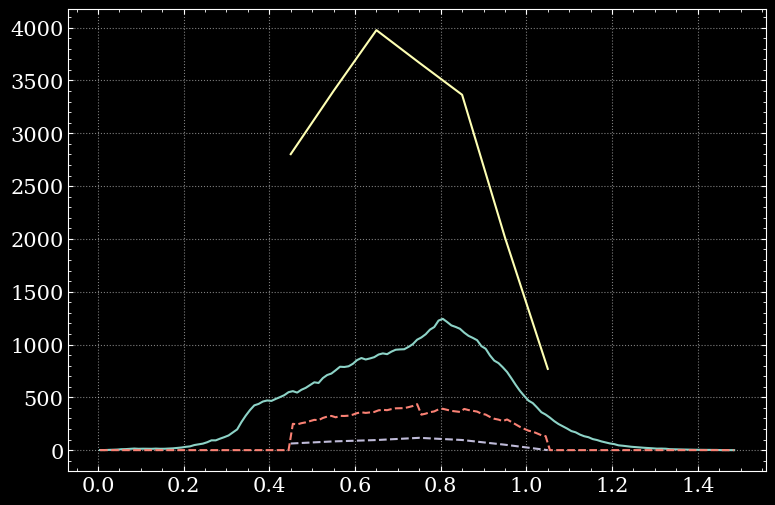

In [324]:
plt.plot(finezs, fineN*100)
plt.plot(coarsezs, coarseN)
plt.plot(coarsezs, np.sum(desi.N(**cpars), axis=1)*Nc_scale, ls='--')
plt.plot(finezs, fineN*Nf_scale, ls='--')

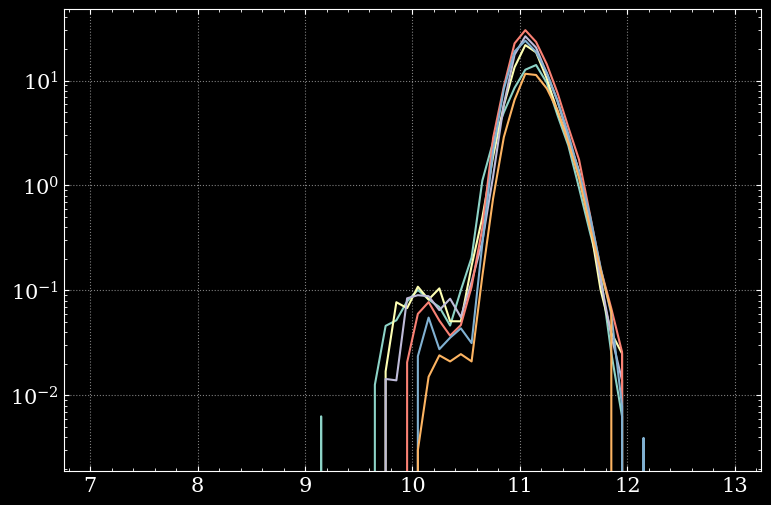

In [265]:
for i in range(coarseNnew.shape[0]):
    plt.plot(desi.logmstar, coarseNnew[i])
plt.yscale('log')

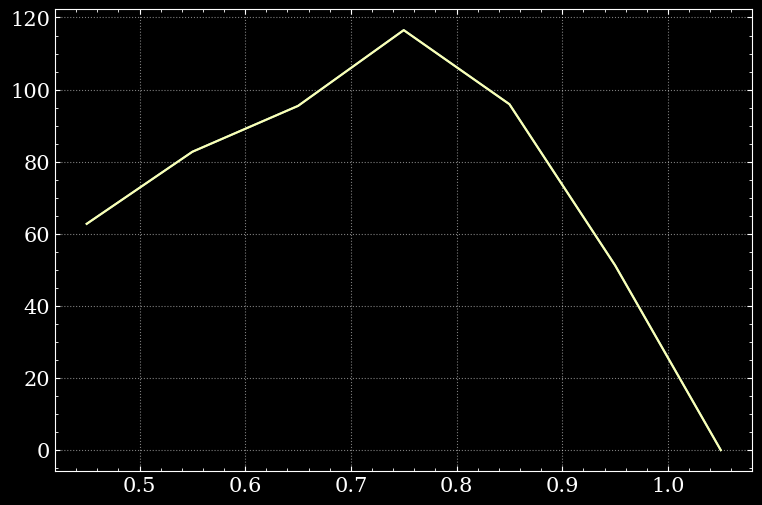

In [180]:
plt.plot(desi.z, newN)
plt.plot(desi.z, np.sum(newNdesi, axis=1))

In [97]:
zs = np.linspace(0, 1, 5)

In [87]:
oldzs

0      0.005
1      0.015
2      0.025
3      0.035
4      0.045
       ...  
144    1.445
145    1.455
146    1.465
147    1.475
148    1.485
Length: 149, dtype: float64

In [68]:
np.arange(kroupass.z[0], kroupass.z[-1]+0.2, 0.1)

array([0.005, 0.105, 0.205, 0.305, 0.405, 0.505, 0.605, 0.705, 0.805,
       0.905, 1.005, 1.105])

In [66]:
pd.cut(zdistdf['zmin'], bins=np.arange(kroupass.z[0], kroupass.z[-1]+0.2, 0.1))

0                 NaN
1      (0.005, 0.105]
2      (0.005, 0.105]
3      (0.005, 0.105]
4      (0.005, 0.105]
            ...      
144               NaN
145               NaN
146               NaN
147               NaN
148               NaN
Name: zmin, Length: 149, dtype: category
Categories (11, interval[float64, right]): [(0.005, 0.105] < (0.105, 0.205] < (0.205, 0.305] < (0.305, 0.405] ... (0.705, 0.805] < (0.805, 0.905] < (0.905, 1.005] < (1.005, 1.105]]

In [63]:
zdistdf.zmax.values[-1:]

array([1.49])

In [64]:
zbins = np.concatenate([zdistdf.zmin.values, zdistdf.zmax.values[-1:]])
N_deg2 = zdistdf[f"{zbin}_{hemisphere}"]

In [ ]:

N_deg2

0      0.001
1      0.001
2      0.002
3      0.005
4      0.005
       ...  
144    0.000
145    0.000
146    0.000
147    0.000
148    0.000
Name: bin_1_combined, Length: 149, dtype: float64

In [39]:
len(os.listdir("/global/cfs/projectdirs/desi/public/ets/vac/stellar_mass/v1/north"))+len(os.listdir("/global/cfs/projectdirs/desi/public/ets/vac/stellar_mass/v1/south"))

740

In [36]:
ViewDataOrganization("/global/cfs/projectdirs/desi/public/ets/vac/stellar_mass/v1/")

### arXiv:2208.08515                  DESI LRG target selection    (Zhou+, 2022)
Target Selection and Validation of DESI Luminous Red Galaxies
    Rongpu Zhou, Biprateep Dey, Jeffrey A. Newman, D. J. Eisenstein, K. Dawson,
    S. Bailey, A. Berti, J. Guy, Ting-Wen Lan, H. Zou, J. Aguilar, S. Ahlen,
    Shadab Alam, D. Brooks, A. de la Macorra, A. Dey, G. Dhungana, K. Fanning,
    A. Font-Ribera, S. Gontcho A Gontcho, K. Honscheid, Mustapha Ishak,
    T. Kisner, A. Kovacs, A. Kremin, M. Landriau, Michael E. Levi,
    C. Magneville, Marc Manera, P. Martini, Aaron M. Meisner, R. Miquel,
    J. Moustakas, Adam D. Myers, Jundan Nie, N. Palanque-Delabrouille,
    W.J. Percival, C. Poppett, F. Prada, A. Raichoor, A. J. Ross, E. Schlafly,
    D. Schlegel, M. Schubnell, Gregory Tarle, B. A. Weaver, R. H. Wechsler,
    Christophe Yèche, Zhimin Zhou

This directory contains the stellar mass catalogs. These catalogs are row-by-row
matched to the sweep catalogs in Legacy Surveys DR9 (https://www.le

In [30]:
zdistdf = pd.read_csv(redshift_dist_file, sep=" ", skiprows=1, names=pd.read_csv(redshift_dist_file, sep=" ").columns[1:])
zdistdf

,zmin,zmax,all_combined,bin_1_combined,bin_2_combined,bin_3_combined,bin_4_combined,all_north,bin_1_north,bin_2_north,bin_3_north,bin_4_north,all_south,bin_1_south,bin_2_south,bin_3_south,bin_4_south
0,0.00,0.01,0.008,0.001,0.001,0.001,0.001,0.009,0.000,0.002,0.002,0.001,0.007,0.001,0.001,0.001,0.001
1,0.01,0.02,0.008,0.001,0.001,0.001,0.001,0.005,0.000,0.002,0.000,0.000,0.010,0.001,0.000,0.002,0.002
2,0.02,0.03,0.023,0.002,0.001,0.002,0.004,0.018,0.000,0.000,0.002,0.007,0.025,0.003,0.002,0.002,0.002
3,0.03,0.04,0.042,0.005,0.005,0.004,0.004,0.039,0.006,0.006,0.006,0.005,0.043,0.004,0.004,0.003,0.004
4,0.04,0.05,0.054,0.005,0.006,0.003,0.002,0.036,0.003,0.005,0.002,0.002,0.062,0.006,0.006,0.003,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,1.44,1.45,0.019,0.000,0.001,0.002,0.001,0.017,0.000,0.002,0.002,0.000,0.019,0.001,0.000,0.002,0.002
145,1.45,1.46,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
146,1.46,1.47,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
147,1.47,1.48,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [ ]:
def volumes(self, zs, hh, T_CMB, Omega_m, Omega_L, Omega_b, **kwargs):
    cosmo = astropy.cosmology.LambdaCDM(H0=hh*100, Tcmb0=T_CMB, Om0=Omega_m, Ode0=Omega_L, Ob0=Omega_b)

    vols = np.array([(cosmo.comoving_volume(z+self.dz/2).value-cosmo.comoving_volume(z-self.dz/2).value)/(1+z)**3 for z in self.z])

    return vols * (self.area/(4*np.pi*(180/np.pi)**2))

In [26]:
zdistdf.bin_1_combined

0      0.001
1      0.001
2      0.002
3      0.005
4      0.005
       ...  
144    0.000
145    0.000
146    0.000
147    0.000
148    0.000
Name: bin_1_combined, Length: 149, dtype: float64

In [ ]:
zdistdf.groupby('zbin')

AttributeError: 'DataFrame' object has no attribute 'group_by'

In [22]:
zdistdf

,zmin,zmax,all_combined,bin_1_combined,bin_2_combined,bin_3_combined,bin_4_combined,all_north,bin_1_north,bin_2_north,bin_3_north,bin_4_north,all_south,bin_1_south,bin_2_south,bin_3_south,bin_4_south,zbin
0,0.00,0.01,0.008,0.001,0.001,0.001,0.001,0.009,0.000,0.002,0.002,0.001,0.007,0.001,0.001,0.001,0.001,NaN
1,0.01,0.02,0.008,0.001,0.001,0.001,0.001,0.005,0.000,0.002,0.000,0.000,0.010,0.001,0.000,0.002,0.002,"(0.005, 0.105]"
2,0.02,0.03,0.023,0.002,0.001,0.002,0.004,0.018,0.000,0.000,0.002,0.007,0.025,0.003,0.002,0.002,0.002,"(0.005, 0.105]"
3,0.03,0.04,0.042,0.005,0.005,0.004,0.004,0.039,0.006,0.006,0.006,0.005,0.043,0.004,0.004,0.003,0.004,"(0.005, 0.105]"
4,0.04,0.05,0.054,0.005,0.006,0.003,0.002,0.036,0.003,0.005,0.002,0.002,0.062,0.006,0.006,0.003,0.002,"(0.005, 0.105]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,1.44,1.45,0.019,0.000,0.001,0.002,0.001,0.017,0.000,0.002,0.002,0.000,0.019,0.001,0.000,0.002,0.002,NaN
145,1.45,1.46,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN
146,1.46,1.47,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN
147,1.47,1.48,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN


In [12]:
kroupass.z

array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285, 0.295, 0.305, 0.315, 0.325, 0.335, 0.345, 0.355,
       0.365, 0.375, 0.385, 0.395, 0.405, 0.415, 0.425, 0.435, 0.445,
       0.455, 0.465, 0.475, 0.485, 0.495, 0.505, 0.515, 0.525, 0.535,
       0.545, 0.555, 0.565, 0.575, 0.585, 0.595, 0.605, 0.615, 0.625,
       0.635, 0.645, 0.655, 0.665, 0.675, 0.685, 0.695, 0.705, 0.715,
       0.725, 0.735, 0.745, 0.755, 0.765, 0.775, 0.785, 0.795, 0.805,
       0.815, 0.825, 0.835, 0.845, 0.855, 0.865, 0.875, 0.885, 0.895,
       0.905, 0.915, 0.925, 0.935, 0.945, 0.955, 0.965, 0.975, 0.985,
       0.995, 1.005])

In [7]:
kroupass = SMFs.BOSSDR10({'group':'portsmouth', 'IMF':'Kroupa', 'template':'passive', 'galaxy':'CMASS'})


In [3]:
import Models.SHMRs as SHMR
import Models.SMFs as SMFs

shmr = SHMR.Kravstov2014({'sample':'Mvir_scatter'})
logmstarmin,logmstarmax = 9.42,11.73

mopc_logmhalos = np.log10(np.genfromtxt("/global/homes/c/cpopik/Capybara/Data/mass_distrib.txt"))
mopc_logmhalo = np.array([[11.31932504, 11.43785913, 11.57526319, 11.74539764, 11.97016907, 12.27689266, 12.67884686, 13.16053855, 13.69871423]]).T
mopc_N = np.array([2.94467222e-06, 2.94467222e-06, 2.94467222e-06, 1.47233611e-05, 3.38637305e-05, 4.13431979e-03, 1.31666601e-01, 3.36540698e-01, 8.13760167e-02])

In [41]:
import Models.SMFs as SMFs
del sys.modules['Models.SMFs']  # Clear the cache to avoid conflicts
import Models.SMFs as SMFs

In [ ]:
kroupass = SMFs.DR10CMASS({'group':'portsmouth', 'IMF':'krou', 'template':'passive'})
salppass = SMFs.DR10CMASS({'group':'portsmouth', 'IMF':'salp', 'template':'passive'})
kroustar = SMFs.DR10CMASS({'group':'portsmouth', 'IMF':'krou', 'template':'starforming'})
salpstar = SMFs.DR10CMASS({'group':'portsmouth', 'IMF':'salp', 'template':'starforming'})

wisc = SMFs.DR10CMASS({'group':'wisconsin', 'pop':'m11'})

In [261]:
Table.read(f"{wisc.path}/{wisc.group}_{wisc.fname}-v5_5_12.fits.gz").columns

<TableColumns names=('PLATE','MJD','FIBERID','RA','DEC','Z','Z_ERR','ZNUM','MSTELLAR_MEDIAN','MSTELLAR_ERR','MSTELLAR_P2P5','MSTELLAR_P16','MSTELLAR_P84','MSTELLAR_P97P5','VDISP_MEDIAN','VDISP_ERR','VDISP_P2P5','VDISP_P16','VDISP_P84','VDISP_P97P5','CALPHA','CALPHA_NORM','SN_MEDIAN','WARNING','LEGACY_TARGET1','LEGACY_TARGET2','SPECIAL_TARGET1','SPECIAL_TARGET2','BOSS_TARGET1','ANCILLARY_TARGET1','ANCILLARY_TARGET2','SPECPRIMARY','SPECOBJID')>

In [267]:
dftestwisc = Table.read(f"{wisc.path}/{wisc.group}_{wisc.fname}-v5_5_12.fits.gz")['Z', wisc.mcolname, 'BOSS_TARGET1', 'SPECPRIMARY'].to_pandas()
dftestmara = Table.read(f"{kroupass.path}/{kroupass.group}_{kroupass.fname}-v5_5_12.fits.gz")['Z', kroupass.mcolname, 'BOSS_TARGET1', 'SPECPRIMARY'].to_pandas()

In [269]:
def decode_bitmask(val):
    """Return a list of bit positions (starting from 0) where bits are 1"""
    return [i for i in range(val.bit_length()) if (val >> i) & 1]

dftestwisc['bits'] = dftestwisc['BOSS_TARGET1'].apply(decode_bitmask)
dftestmara['bits'] = dftestmara['BOSS_TARGET1'].apply(decode_bitmask)


In [ ]:
(shmr.SHMR(dftestmara.LOGMASS)>12)

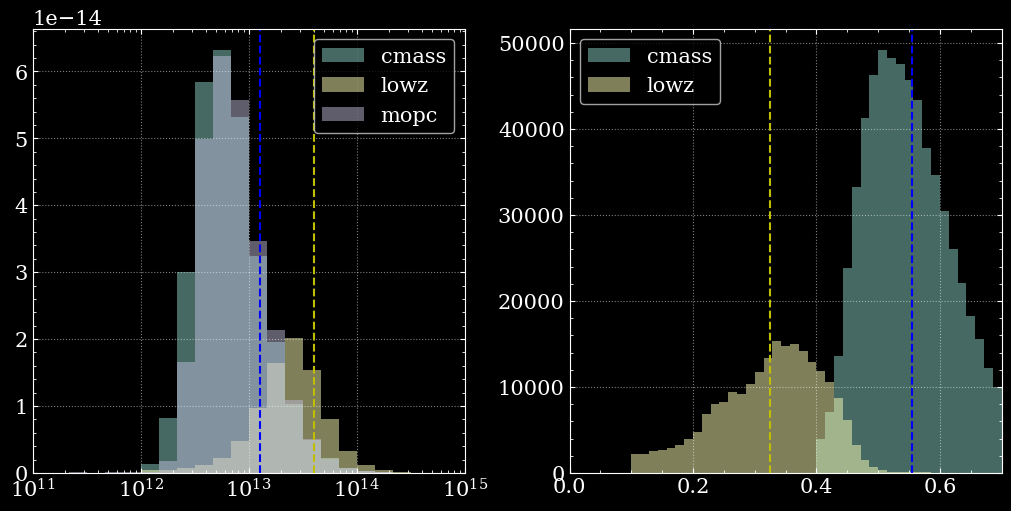

In [337]:
logms_cmass =dftestmara[(dftestmara["bits"].apply(lambda bits: (7 in bits))) &
                        (shmr.SHMR(dftestmara.LOGMASS)>12) & (dftestmara.Z>0.4)]
logms_lowz = dftestwisc[(dftestwisc["bits"].apply(lambda bits: (0 in bits))) & 
                        (shmr.SHMR(dftestwisc.MSTELLAR_MEDIAN)>12) & (dftestwisc.Z>0.1)]

fig, axs = plt.subplots(1, 2, figsize=(10, 5), layout='constrained')

axs[0].hist(10**shmr.SHMR(logms_cmass.LOGMASS), bins=np.logspace(11, 15, 25), label='cmass', alpha=0.5, density=True);
axs[0].hist(10**shmr.SHMR(logms_lowz.MSTELLAR_MEDIAN), bins=np.logspace(11, 15, 25), label='lowz', alpha=0.5, density=True);
axs[0].hist(10**mopc_logmhalos, bins=np.logspace(11, 15, 25), label='mopc', alpha=0.5, density=True);


axs[0].axvline(10**shmr.SHMR(logms_cmass.LOGMASS.mean()), ls='--', c='blue')
axs[0].axvline(10**shmr.SHMR(logms_lowz.MSTELLAR_MEDIAN.mean()), ls='--', c='y')

axs[0].set(xlim=(1e11, 1e15), xscale='log')
axs[0].legend()


axs[1].hist(logms_cmass.Z, bins=np.linspace(0, 0.7, 50), label='cmass', alpha=0.5);
axs[1].hist(logms_lowz.Z, bins=np.linspace(0, 0.7, 50), label='lowz', alpha=0.5);

axs[1].axvline(logms_cmass.Z.mean(), ls='--', c='blue')
axs[1].axvline(logms_lowz.Z.mean(), ls='--', c='y')

axs[1].set(xlim=(0, 0.7))
axs[1].legend()

In [343]:
mopc_logmhalos

array([12.88014519, 13.35407476, 12.86155857, ..., 12.84307884,
       12.73448927, 13.13065035])

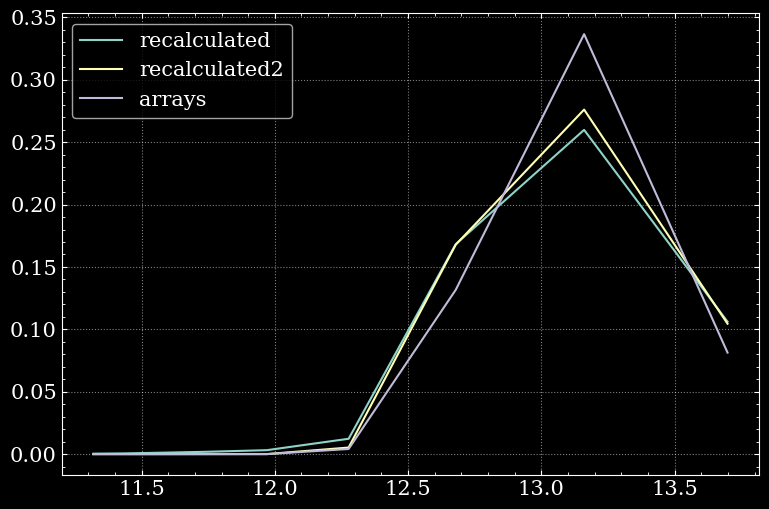

In [352]:
logms_cmass =dftestmara[(dftestmara["bits"].apply(lambda bits: (1 in bits)))]
h, b_edges = np.histogram(logms_cmass.LOGMASS, bins=np.linspace(9.42, 11.73, 10))
b_cen = np.array([(b_edges[i]+b_edges[i-1])*0.5 for i in range(1,len(b_edges))])
b_len = np.array([(b_edges[i]-b_edges[i-1]) for i in range(1,len(b_edges))])
integ = np.sum(10**b_len*h)
p = h/integ
plt.plot(shmr.SHMR(b_cen), p, label='recalculated')

h, b_edges = np.histogram(shmr.HSMR(mopc_logmhalos), bins=np.linspace(9.42, 11.73, 10))
b_cen = np.array([(b_edges[i]+b_edges[i-1])*0.5 for i in range(1,len(b_edges))])
b_len = np.array([(b_edges[i]-b_edges[i-1]) for i in range(1,len(b_edges))])
integ = np.sum(10**b_len*h)
p = h/integ
plt.plot(shmr.SHMR(b_cen), p, label='recalculated2')


plt.plot(mopc_logmhalo, mopc_N, label='arrays')
plt.legend()

In [10]:
p

array([1.04087299e-05, 1.01113376e-04, 3.47012185e-02, 1.54896770e-01,
       1.08353391e-01, 3.04157957e-02, 5.58502707e-03, 5.96271527e-04,
       2.52783440e-05])

In [5]:
np.mean(mopc_logmhalo)

13.142377092032541

In [223]:
import Models.SMFs as SMFs
del sys.modules['Models.SMFs']
import Models.SMFs as SMFs

In [235]:
cmass = SMFs.DR10CMASS({'group':'portsmouth', 'template':'passive', 'IMF':'krou'})

In [ ]:
np.sum(np.sum(cmass.N, axis=0)/np.sum(cmass.N)*cmass.logmstar)

array([1.01193829e-07, 3.82737001e-08, 2.42438412e-08, 1.90467149e-08,
       1.67808347e-08, 1.58430894e-08, 1.56449179e-08, 1.59286215e-08,
       1.65686106e-08, 1.75000472e-08, 1.86891563e-08])

In [ ]:
np.trapz(np.sum(cmass.dndlogm(**cpars)*cmass.volumes(**cpars)[:, ], axis=0), cmass.logmstar)

933157.500000001

In [231]:
cmass.logmstar

array([ 8.05,  8.15,  8.25,  8.35,  8.45,  8.55,  8.65,  8.75,  8.85,
        8.95,  9.05,  9.15,  9.25,  9.35,  9.45,  9.55,  9.65,  9.75,
        9.85,  9.95, 10.05, 10.15, 10.25, 10.35, 10.45, 10.55, 10.65,
       10.75, 10.85, 10.95, 11.05, 11.15, 11.25, 11.35, 11.45, 11.55,
       11.65, 11.75, 11.85, 11.95, 12.05, 12.15, 12.25, 12.35, 12.45,
       12.55, 12.65, 12.75, 12.85, 12.95, 13.05, 13.15, 13.25, 13.35,
       13.45, 13.55, 13.65, 13.75, 13.85, 13.95])

In [218]:
desi = SMFs.DESI1Percent({'zbin':'bin_4', 'sample':'LRG', 'hemisphere':'combined', 'zweight':'False'})

In [ ]:
cmass.addcuts(mstarmin=8)

In [221]:
np.sum(desi.N(**cpars))

17592.571984230664

In [208]:
cpars = {'hh':0.7,"T_CMB":2.7,"Omega_m":0.3,"Omega_b":0.05,"Omega_L":0.7}

In [245]:
np.genfromtxt("/global/homes/c/cpopik/Capybara/Data/cov_diskring_tsz_varweight_bootstrap.txt").shape

(9, 9)

(None, <matplotlib.legend.Legend at 0x7f7720146e00>)

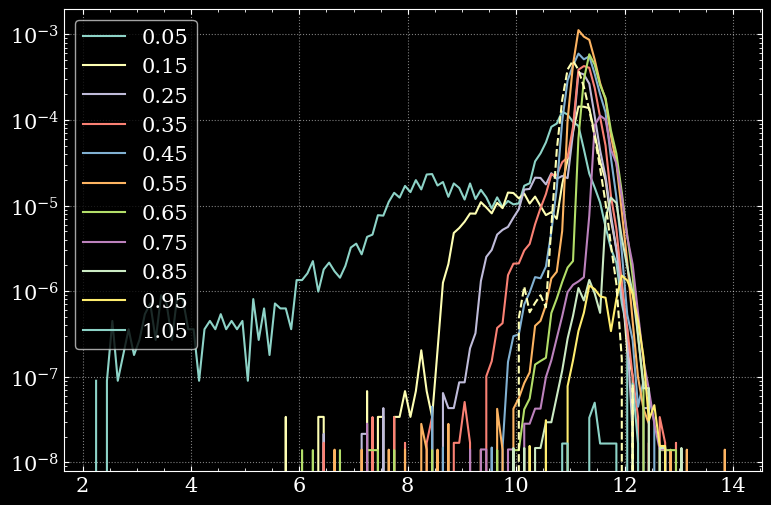

In [212]:
for i in range(cmass.z.size):
    plt.plot(cmass.logmstar, cmass.dndlogm(**cpars)[i], label=f'{cmass.z[i]:.2f}')

plt.plot(desi.logmstar, desi.dndlogmstar(**cpars)[4], ls='--')
plt.yscale('log'), plt.legend()

In [170]:
(cmass.area/4*np.pi*(180/np.pi)**2)

16432085.78967493

In [86]:
(2*np.pi*u.sr).to(u.deg**2)

<Quantity 20626.48062471 deg2>

In [83]:
np.sum(smf.n_to_N(0.7, 2.7, 0.3, 0.7, 0.05)[:, None]*smf.dndlogmstar)*0.7**3

5183897.788164904

In [39]:
pd.read_csv(f"{smf.path}/Fig1_{smf.sample}_z0.8.txt", sep=' ', names=['Mstar',f"n", f"err"], usecols=[0]).Mstar.values

array([ 7.05,  7.15,  7.25,  7.35,  7.45,  7.55,  7.65,  7.75,  7.85,
        7.95,  8.05,  8.15,  8.25,  8.35,  8.45,  8.55,  8.65,  8.75,
        8.85,  8.95,  9.05,  9.15,  9.25,  9.35,  9.45,  9.55,  9.65,
        9.75,  9.85,  9.95, 10.05, 10.15, 10.25, 10.35, 10.45, 10.55,
       10.65, 10.75, 10.85, 10.95, 11.05, 11.15, 11.25, 11.35, 11.45,
       11.55, 11.65, 11.75, 11.85, 11.95, 12.05, 12.15, 12.25, 12.35,
       12.45, 12.55, 12.65, 12.75, 12.85, 12.95])

In [32]:
np.trapz(smf.dndlogmstar, smf.logmsstar)

ValueError: operands could not be broadcast together with shapes (1,58) (6,59) 

# Emily/Stefania's mdist

In [ ]:
mfile = "/global/homes/c/cpopik/Capybara/Data/mass_distrib.txt"
logmraws = np.log10(np.genfromtxt(mfile))
mbins = np.arange((np.floor(logmraws.min()*10)/10).round(1), (np.ceil(logmraws.max()*10)/10+0.1).round(1), 0.1)
SMF, mstars = np.histogram(logmraws, bins=mbins)
SMF = SMF[None, :]
zs = np.array([0.55])

# Liu Measurements

In [ ]:
zdist = np.genfromtxt('/global/homes/c/cpopik/Capybara/Data/Liu2025/fig2_main_lrg_pz_dndz_iron_v0.4_dz_0.01.txt')
CIBdp = pd.read_csv('/global/homes/c/cpopik/Capybara/Data/Liu2025/fig3.csv')
CIBdBetadp = pd.read_csv('/global/homes/c/cpopik/Capybara/Data/Liu2025/fig4.csv')
CAPcorrmat = {f"zbin{i}": np.load(f'/global/homes/c/cpopik/Capybara/Data/Liu2025/fig6_pz{i}.npy') for i in range(1, 5)}
CIBdp_noncum = pd.read_csv('/global/homes/c/cpopik/Capybara/Data/Liu2025/fig7.csv')
CIBdBetadp_noncum = pd.read_csv('/global/homes/c/cpopik/Capybara/Data/Liu2025/fig8.csv')
CAPcorrmat_noncum = {f"zbin{i}": np.load(f'/global/homes/c/cpopik/Capybara/Data/Liu2025/fig9_pz{i}.npy') for i in range(1, 5)}
CIBdp_TCIB24 = pd.read_csv('/global/homes/c/cpopik/Capybara/Data/Liu2025/fig10.csv')
CIBdBetadp_TCIB24 = pd.read_csv('/global/homes/c/cpopik/Capybara/Data/Liu2025/fig11.csv')
DR5CAP = pd.read_csv('/global/homes/c/cpopik/Capybara/Data/Liu2025/fig12.csv')
DR5ringring = pd.read_csv('/global/homes/c/cpopik/Capybara/Data/Liu2025/fig13.csv')

In [ ]:
plt.errorbar(Liu2025.thetas, Liu2025.tSZdata, np.diag(Liu2025.tSZcov)**0.5, capsize=4, label='for Nick')
plt.errorbar(CIBdBetadp['RApArcmin'], CIBdBetadp['pz1_act_dr6_Beta_1.2'], CIBdBetadp['pz1_act_dr6_Beta_1.2_err'], capsize=4, label='CIB dBeta dp')

plt.legend()

In [ ]:
CIBdBetadp['pz1_act_dr6_Beta_1.2_err']

In [ ]:
stddevs = CIBdBetadp['pz2_act_dr6_Beta_1.4_err'][:-1].values
covmat_maybe = np.outer(stddevs, stddevs)*CAPcorrmat['zbin1']
np.diag(covmat_maybe)**0.5

# Mass conversion

In [ ]:
pyccl.halos.concentration.diemer15

In [ ]:
import pyccl

In [ ]:
pyccl.halos.concentration.ConcentrationDiemer15.

In [ ]:
cosmo = pyccl.Cosmology(h=0.7, Omega_c=0.25, Omega_b=0.044, n_s=0.95, sigma8=0.8,transfer_function='bbks')

massconv = pyccl.halos.massdef.mass_translator(mass_in='200c', mass_out='vir',
                                    concentration='Diemer15')

In [ ]:
np.log10(massconv(cosmo, 1e12, 1/(1+0.54)))

# Dust

In [ ]:
schaan = Measurements.Schaan2021()

fact = (schaan.T_CMB*1e6)*(Measurements.fnu(schaan.freq, schaan.T_CMB))*4.54591666
plt.errorbar(schaan.thetas, schaan.tSZdata*fact, -schaan.tSZerr*fact)
plt.plot(schaan.thetas, schaan.dustprof*fact)

np.genfromtxt("/global/homes/c/cpopik/fig6_TNG_H_dust.txt").T

In [82]:
def aperture_photometry(thts, prof2D_beam, NNR, disc_fac):
    sig_all_p_beam = [] 
    for tht in thts:
        dtht_use = np.arctan(np.arctan(np.radians(tht / 60.0))) / NNR
        thta_use = (np.arange(NNR) + 1.0) * dtht_use
        sig_p = 2.0 * np.pi * dtht_use * np.sum(thta_use * prof2D_beam(thta_use))

        dtht2_use = np.arctan(np.arctan(np.radians(tht * disc_fac / 60.0))) / NNR
        thta2_use = (np.arange(NNR) + 1.0) * dtht2_use
        sig2_p = 2.0 * np.pi * dtht2_use * np.sum(thta2_use * prof2D_beam(thta2_use))

        sig_all_p_beam.append(sig_p-(sig2_p-sig_p))

    return np.array(sig_all_p_beam)

In [290]:
A_dust = 0.2*(u.kJy/u.sr)
T_dust = 20*u.K
beta_dust = 1.1
c0 = 5
c1 = -1.5
c2 = 0.1

def x(nu, T):
    return (nu*c.h/c.k_B/T).decompose()

def dB_dT(nu, T):
    return (2 * c.k_B*nu**2/c.c**2 * x(nu, T)**2 * np.exp(x(nu, T)) /
             ((np.exp(x(nu, T)) - 1)**2))/u.sr

def dust(nu, R, T, nu0):
    return A_dust*(nu*(1+z)/nu0)**(beta_dust+3) * (np.exp(x(nu0, T))-1)/(np.exp(x(nu*(1+z), T))-1) * (c0+c1*R+c2*R**2)

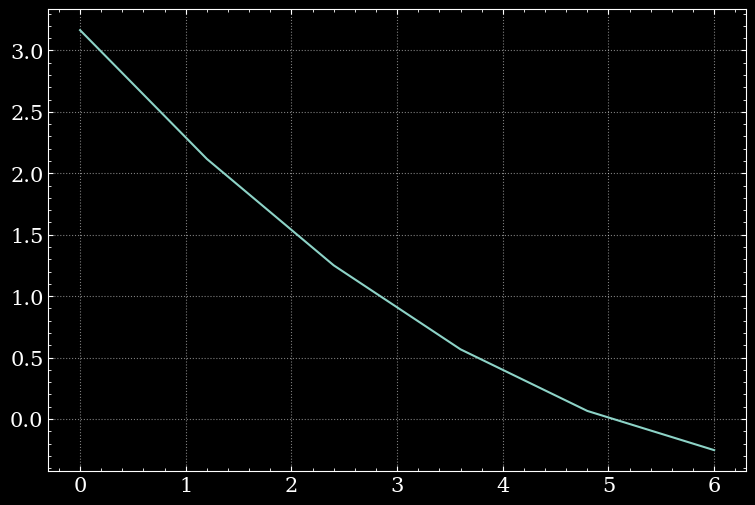

In [300]:
thetas = np.linspace(0, 6, 6)
T_CMB = 2.7*u.K
nu0 = (c.c/(90*u.um)).to(u.GHz)
nu = (c.c/(250*u.um)).to(u.GHz)
z = 0.55

plt.plot(thetas, dust(nu, thetas, T_dust, nu0))

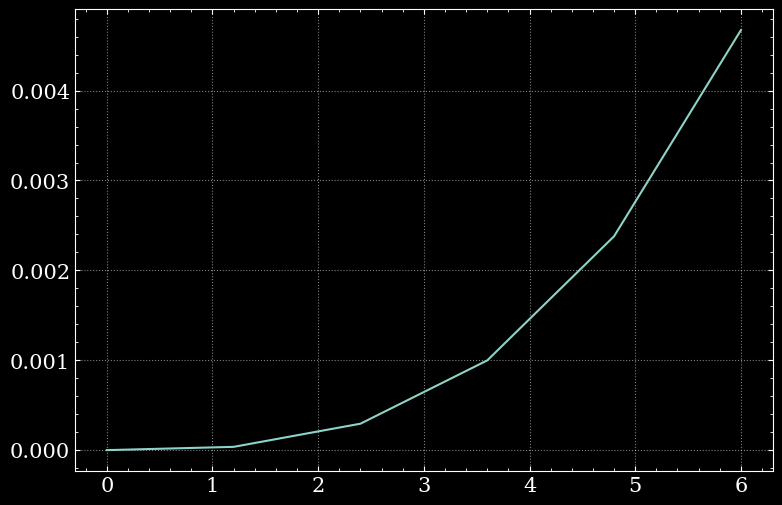

In [313]:
dustprof = lambda theta: (dust(nu, theta, T_dust, nu0)/dB_dT(nu, T_dust)).to(u.uK).value
plt.plot(thetas, aperture_photometry(thetas, dustprof, 100, np.sqrt(2))*(u.sr.to(u.arcmin**2)))

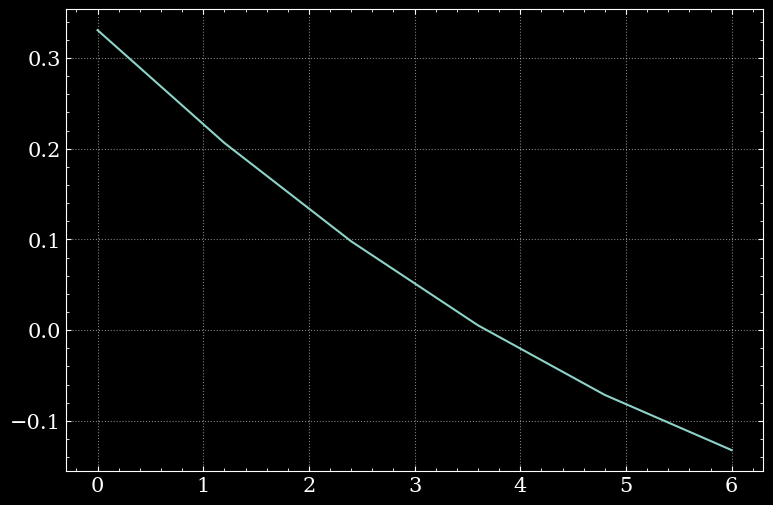

In [25]:
thetas = np.linspace(0, 6, 6)
plt.plot(thetas, dust(150*u.GHz, thetas))

In [ ]:
plt.plot(model.thetas, dust(150*u.GHz, model.thetas))

In [ ]:
(dust(150*u.GHz, model.thetas)*c.sigma_T/c.c**2/c.m_e*4*np.pi*u.sr).decompose()